# PROVASBRDDTS

**Questo notebook serve a processare i dati relativi ai subreddit e a produrre come output un csv con autori sulle righe e relative predicted_proba del modello finale di questo notebook**

Procediamo analizzando la matrice di dati con i 3 modelli più performanti. Prendo poi le predicted proba di quei 3 diversi modelli per allenare una LogisticRegression che restituisce una predcted_proba per ciascun autore

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load the train data

In [2]:
train_data = pd.read_csv('/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/train_data.csv', encoding="utf8")

In [3]:
train_data.head()
#shape(train_data)

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [4]:
train_data.author.unique().shape


(5000,)

In [5]:
target = pd.read_csv('/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/train_target.csv')

In [6]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


# Feature Extraction

**Subreddits exctraction**

In [7]:
subreddits = train_data.subreddit.unique() # vett. dei subreddits:
                                           # prende da subreddit di train_data contandoli una sola volta {unique()}
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0])) #pd.Series: indicizza i subreddit.
                                           # vett. (nomesubreddit, etichetta)

In [8]:
from scipy import sparse

In [9]:
def extract_features(group):                        # prende l'autore
    
    group_subreddits = group['subreddit'].values    # vett. dei nomi dei subreddit 
                                                    
    idxs = subreddits_map[group_subreddits].values  # vettore etichette subreddit
    
    v = sparse.dok_matrix((1, subreddits.shape[0])) # matrice sparsa 1xN°subreddit diversi
    
    for idx in idxs:
        if not np.isnan(idx):   #per ogni etichetta non nulla assegno 1 nella matrice sparsa
                                #per ogni autore assegno a Vij il valore 1 se l'autore ha partecipato al subreddit
                                
            v[0, idx] = 1
            
    return v.tocsr()            #converto v in formato csr

#es: creo v: vettore riga sparso che indica in quali subreddit RedThunder90 ha partecipato
extract_features(train_data[train_data.author=='RedThunder90'])

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [10]:
features_dict = {}     #creo dizionario delle features
                       #associa a ogni autore il suo vettore riga v che indica i subreddits in cui ha partecipato

for author, group in train_data.groupby('author'):  
    features_dict[author] = extract_features(group)

In [11]:
X = sparse.vstack([features_dict[author] for author in target.author])

In [12]:
y = target.gender

In [13]:

Xarray=X.toarray()

X1 = Xarray #nel caso voglia solo i subreddits


In [14]:
from sklearn.model_selection import StratifiedKFold, train_test_split

#nfold = StratifiedKFold(n_splits=5)
# Takes group information into account to avoid 
# building folds with imbalanced class distributions 
#(for binary or multiclass classification tasks).

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=.2, random_state = 32)


# Model Selection - SUBREDDITS

In [15]:
# importo cose utili
from sklearn.model_selection import cross_val_score, GridSearchCV

#importo i modelli
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict

# creo dizionario dei modelli di classificazione
# Multinomial Naive Bayes non funziona perchè dopo la PCA i dati possono assumere valori negativi (in X hanno valore 0 o 1 a seconda che l'autore abbia o no partecipato al subreddit)
#PERCHé assumono vaori anche negativi? perchè sono nuove features combo lineari degli 0 e 1?
models = OrderedDict([
          ('Knn 5', KNeighborsClassifier(4)),
          ('Gaussian Naive Bayes', GaussianNB()),
          ('Multinomial Naive Bayes', MultinomialNB()),
          ('Logistic Regression', LogisticRegression(solver='liblinear')), #uso liblinear, mlto efficiente su large and sparse datasets
          #('Linear SVM', SVC(kernel='linear', probability=True)),
          #('Poly SVM', SVC(kernel='poly', degree=2, probability=True)),
          #('RBF SVM', SVC(kernel='rbf', gamma=2, C=1, probability=True)),
          ('Classification Tree', DecisionTreeClassifier(max_depth=5)),
          ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=100)),
          ('Multilayer Perceptron', MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0))
          ])

In [16]:
#fitto e calcolo lo score per ogni modello e stampo il migliore

best_score=.0
best_name=' '

for name in models:
    clf = models[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score>best_score:
        best_score=score
        best_name=name
    print(name, score)
    
print('\nBest model is ', best_name, 'with a score = ', best_score)

Knn 5 0.746
Gaussian Naive Bayes 0.65
Multinomial Naive Bayes 0.871
Logistic Regression 0.865
Classification Tree 0.814
Random Forest 0.74
Multilayer Perceptron 0.869

Best model is  Multinomial Naive Bayes with a score =  0.871


# Logistic Regression - SUBREDDITS


Guardo quale sarebbe il C di regolarizzazione migliore: prima approx

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]

Best C: 1.0

Best score: 0.865 



Text(0, 0.5, 'Score (accuracy)')

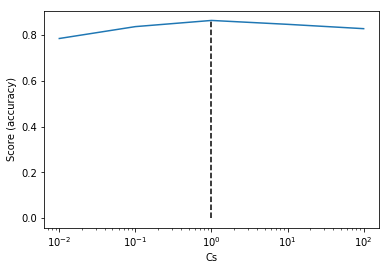

In [17]:
creg=logspace(-2,2,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

semilogx(creg, scores)
plt.vlines(creg[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Cs')
plt.ylabel('Score (accuracy)')

Trovo dalla prima ricerca che C=1 è il migliore, raffino la ricerca

In [18]:
creg=linspace(bestcreg-0.5,bestcreg+0.5,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')


[0.5  0.75 1.   1.25 1.5 ]

Best C: 0.75

Best score: 0.865 



C=1.5, raffino

In [19]:
creg=linspace(bestcreg-0.25,bestcreg+0.25,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')


[0.5   0.625 0.75  0.875 1.   ]

Best C: 0.875

Best score: 0.866 



C=1.5, mi sto divertendo e funziona tutto: ne faccio un'altra

In [20]:
creg=linspace(bestcreg-0.125,bestcreg+0.125,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))

print('Scores: ', scores)
bestcreg = creg[np.argmax(scores)]

print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

[0.75   0.8125 0.875  0.9375 1.    ]
Scores:  [0.865, 0.866, 0.866, 0.865, 0.865]

Best C: 0.8125

Best score: 0.866 



ok, basta che sto esagerando

# Multilayer Perceptron - SUBREDDITS

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]

Best Alpha: 0.0001

Best score: 0.869 

Scores:  [0.869, 0.866, 0.867, 0.869, 0.865, 0.737, 0.737, 0.737, 0.737, 0.737]


Text(0, 0.5, 'Score (accuracy)')

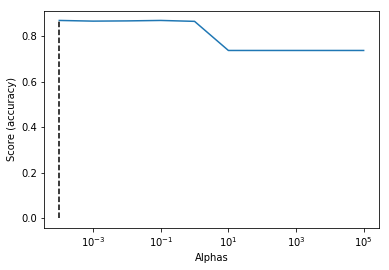

In [21]:
alphas=logspace(-4,5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ',scores)


semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')
    

Raffino la ricerca su alpha

[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]

Best Alpha: 0.046415888336127774

Best score: 0.871 

Scores:  [0.869, 0.866, 0.866, 0.866, 0.866, 0.868, 0.871, 0.87, 0.858, 0.865]


Text(0, 0.5, 'Score (accuracy)')

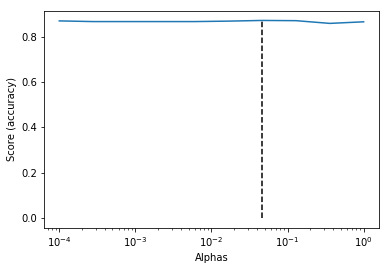

In [22]:
alphas=logspace(-4,0,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

Provo ancora

In [23]:
a=log10(bestalpha)
a

-1.3333333333333335

[0.01467799 0.01895736 0.02448437 0.03162278 0.04084239 0.05274997
 0.06812921 0.08799225 0.11364637 0.14677993]

Best Alpha: 0.05274997063702617

Best score: 0.871 



Text(0, 0.5, 'Score (accuracy)')

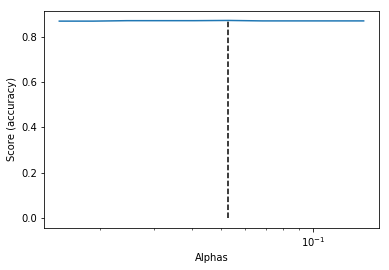

In [24]:

alphas=logspace(a-0.5,a+0.5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')



Tengo questo

# MULTINOMIAL NAIVE BAYES - SUBREDDITS

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]

Best Alfa: 1.0

Best score: 0.871 

Scores:  [0.854, 0.86, 0.865, 0.871, 0.806]


Text(0, 0.5, 'Score (accuracy)')

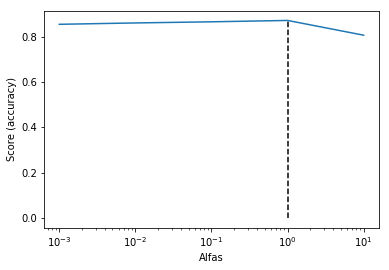

In [25]:
alfas=logspace(-3,1,5)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')
    

Riprovo

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]

Best Alfa: 0.774263682681127

Best score: 0.874 

Scores:  [0.865, 0.867, 0.872, 0.872, 0.874, 0.868, 0.862, 0.851, 0.836, 0.806]


Text(0, 0.5, 'Score (accuracy)')

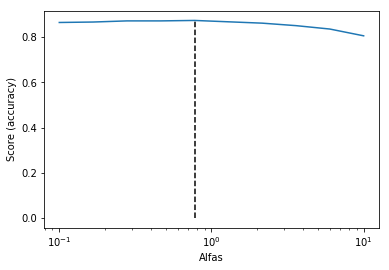

In [26]:
alfas=logspace(-1,1,10)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

Raffino

[0.1        0.12915497 0.16681005 0.21544347 0.27825594 0.35938137
 0.46415888 0.59948425 0.77426368 1.        ]

Best Alfa: 0.774263682681127

Best score: 0.874 

Scores:  [0.865, 0.867, 0.867, 0.87, 0.872, 0.873, 0.872, 0.872, 0.874, 0.871]


Text(0, 0.5, 'Score (accuracy)')

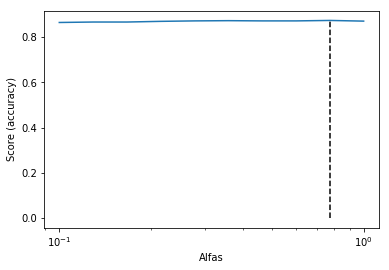

In [27]:
alfas=logspace(-1,0,10)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')


perfetto, così mi piace

## **CALCOLO LE PREDICTED PROBA DEI 3 MODELLI PER I SUBREDDITS**

In [28]:
#Uso tutto il dataset X1 per allenare i migliori modelli trovati

LogReg=LogisticRegression(solver='liblinear', C=bestcreg).fit(X1,y)

MLP=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=bestalpha).fit(X1,y)

MNB=MultinomialNB(alpha=bestalfa).fit(X1,y)

#prendo solo la seconda colonna, ovvero la probabilità che gender=1 (donna)
proba1=LogReg.predict_proba(X1)[:,1]
proba2=MLP.predict_proba(X1)[:,1]
proba3=MNB.predict_proba(X1)[:,1]

In [29]:
Proba1=reshape(proba1,(5000,1))
Proba2=reshape(proba2,(5000,1))
Proba3=reshape(proba3,(5000,1))
shape(Proba1)

(5000, 1)

In [30]:
PTOT=hstack([Proba1,Proba2,Proba3])
shape(PTOT)

(5000, 3)

## Model Selection for final merging

In [31]:
X_train, X_test, y_train, y_test = train_test_split(PTOT, y, test_size=.2, random_state = 32)

In [32]:
best_score=.0
best_name=' '

for name in models:
    clf = models[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score>best_score:
        best_score=score
        best_name=name
    print(name, score)
    
print('\nBest model is ', best_name, 'with a score = ', best_score)

Knn 5 0.915
Gaussian Naive Bayes 0.906
Multinomial Naive Bayes 0.737
Logistic Regression 0.925
Classification Tree 0.917
Random Forest 0.918
Multilayer Perceptron 0.92

Best model is  Logistic Regression with a score =  0.925


## LOGISTIC REGRESSION ON SUBREDDITS DATA FROM MODELS

In [33]:
Cs=logspace(-3,6,10)

for c in Cs:
    LRTOT=LogisticRegression(solver='liblinear', C=c).fit(X_train,y_train)
    score=LRTOT.score(X_test, y_test)
    print('Score = ', score,' C= ', c)

Score =  0.832  C=  0.001
Score =  0.915  C=  0.01
Score =  0.919  C=  0.1
Score =  0.925  C=  1.0
Score =  0.925  C=  10.0
Score =  0.925  C=  100.0
Score =  0.925  C=  1000.0
Score =  0.925  C=  10000.0
Score =  0.925  C=  100000.0
Score =  0.925  C=  1000000.0


Scelgo C=1 (la regolarizzazione più forte che mi massimizza lo score) e alleno logreg ottimizzata su tutti i dati

In [40]:
LRFINALE=LogisticRegression(solver='liblinear', C=1).fit(PTOT,y)
predictions_output = LRFINALE.predict_proba(PTOT)[:,1]
predictions_output


array([0.05860933, 0.94318996, 0.02780333, ..., 0.01955518, 0.30356689,
       0.01371703])

# Export train data to csv
**Esporto le predicted proba del modello finale sul train set da usare in MERGINGDATA.ipynb**

In [36]:
SBRDDTS_train_output = pd.DataFrame({"author":train_data.author.unique(), "SBRDDTS":predictions_output})
#SBRDDTS_train_output.head()
SBRDDTS_train_output.tail()

,author,TFIDF
4995,BrennanDobak,0.015008
4996,J_Mallory,0.996071
4997,MasonJarTeaDrinker,0.019555
4998,Thegirlonfire5,0.303567
4999,emptyRR,0.013717


In [37]:
SBRDDTS_train_output.to_csv("SBRDDTS_train_output.csv", index=False)

# Prepare the solution

## Load Data

In [35]:
test_data = pd.read_csv("/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/test_data.csv", encoding="utf8")

In [36]:
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


## Features Extraction

In [37]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [38]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])

In [39]:
type(X_test)

numpy.ndarray

In [39]:
Xtest=X_test.toarray()

In [40]:
Xtest.shape

(15000, 3468)

**Calcolo i pesi secondo i tre modelli ottimizzati prima**

In [41]:
prob1=LogReg.predict_proba(Xtest)[:,1]
prob2=MLP.predict_proba(Xtest)[:,1]
prob3=MNB.predict_proba(Xtest)[:,1]

Prob1=reshape(prob1,(15000,1))
Prob2=reshape(prob2,(15000,1))
Prob3=reshape(prob3,(15000,1))
shape(Prob1)

(15000, 1)

In [42]:
XTOT=hstack([Prob1,Prob2,Prob3])
shape(XTOT)

(15000, 3)

**Uso dati mangiati dai tre esperimenti per fittare con logistic regression ottimizzata prima e ottenere le mie predizioni sul test set**

In [43]:
y_pred=LRFINALE.predict_proba(XTOT)[:,1]

In [44]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head()

,author,gender
0,ejchristian86,0.996875
1,ZenDragon,0.014150
2,savoytruffle,0.016166
3,hentercenter,0.023449
4,rick-o-suave,0.195290


In [45]:
solution.to_csv("solutionSBRDDTS.csv", index=False)

In [46]:
%%sh
head solution.csv

author,gender
ejchristian86,0.9968754552048945
ZenDragon,0.014149796167168176
savoytruffle,0.01616551798639555
hentercenter,0.023448505273895227
rick-o-suave,0.19528950900299286
olivermihoff,0.018600436385778924
Cleriesse,0.8910134892625196
murderer_of_death,0.013754724251055768
SpiralSoul,0.014142551441020595
